In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt

In [2]:
im_path = '/home/noxd/Home2/datos/Indice y Grado de Marginación municipal, por localidad y ageb, 2010-2015/shape/imm2015.gpkg'

In [55]:
# Carga las geometrías de autoridad local utilizando su ID como índice
im = gpd.read_file(im_path).set_index('CVE_MUN')

In [4]:
im.head()

,NOM_MUN,POB_TOT,ANALF,SPRIM,OVSDE,OVSEE,OVSAE,VHAC,OVPT,PL_5000,PO2SM,IM,GM,CVE_ENT,NOM_ENT,area,perimeter,geometry
CVE_MUN,,,,,,,,,,,,,,,,,,
1,17001,0.0,17772.0,9.07,21.45,2.89,0.38,3.98,31.65,5.46,68.46,48.64,-0.530000000000000,Bajo,17,0.010035,0.728511,"MULTIPOLYGON (((-99.41078 18.65486, -99.39921 ..."
2,17002,0.0,22079.0,6.30,20.12,1.41,1.84,17.54,32.27,9.35,57.97,46.38,-0.420000000000000,Medio,17,0.006808,0.447824,"MULTIPOLYGON (((-98.85733 18.97459, -98.85794 ..."
3,17003,0.0,35689.0,10.29,26.18,3.16,0.68,15.53,35.43,8.00,48.04,69.64,-0.060000000000000,Medio,17,0.012108,0.695140,"MULTIPOLYGON (((-98.72375 18.60630, -98.72328 ..."
4,17004,0.0,85521.0,6.96,20.50,2.22,0.75,4.28,30.69,6.14,51.48,51.12,-0.640000000000000,Bajo,17,0.032299,1.527230,"MULTIPOLYGON (((-99.01149 18.81020, -99.01027 ..."
5,17005,0.0,9768.0,9.12,28.80,5.20,1.03,1.92,29.49,3.96,100.00,59.54,-0.210000000000000,Medio,17,0.007144,0.602679,"MULTIPOLYGON (((-99.42058 18.80154, -99.40419 ..."


In [57]:
im.crs

<Geographic 2D CRS: EPSG:8992>
Name: ITRF92
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: International Terrestrial Reference Frame 1992
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [68]:
gim = gpd.GeoDataFrame(im, crs= {"init": "epsg:8992"})


/home/noxd/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/noxd/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  """Entry point for launching an IPython kernel.


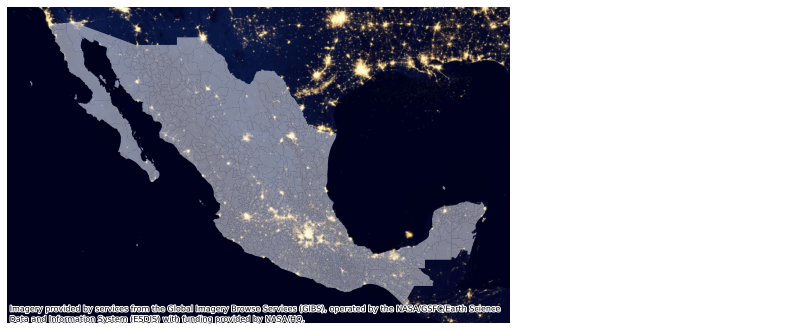

In [78]:
# Create a georeferenced dataframe  
# Transformcona a Web Mercator CRS y grafica 
ax = gim.to_crs(epsg=3857).plot(figsize=(9, 9), alpha=0.5, color='white');
# Agrega mapa base
ctx.add_basemap(ax, source=ctx.providers.NASAGIBS.ViirsEarthAtNight2012)
ax.set_axis_off()
plt.show()

Text(0.5, 1.0, 'Índice de Marginación por municipio')

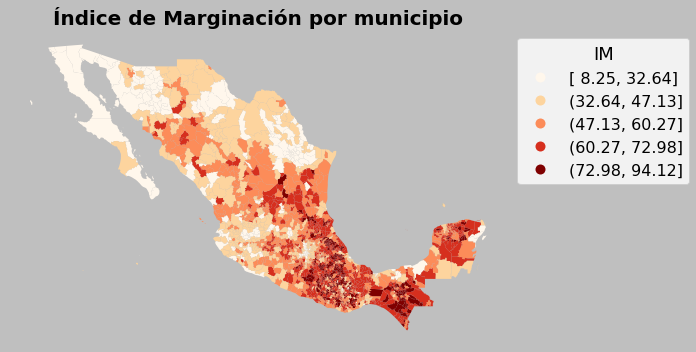

In [5]:
leg_kwds={'title':'IM','frameon':True,'fontsize': 16,
          'title_fontsize':18 , 'bbox_to_anchor':(1,1),'loc':'upper left'}

# Se ajusta la figura y los ejes
f, ax = plt.subplots(1, figsize=(9, 9))
# Grafica % en favor 
im.plot(column='IM', cmap='OrRd', scheme='NaturalBreaks', 
        legend=True,  legend_kwds=leg_kwds, ax=ax)
# Remueve el marco de los ejes
ax.set_axis_off()
# Cambia el color de fondo
f.set_facecolor('0.75')
# Titulo
plt.title("Índice de Marginación por municipio", fontsize=20, fontweight='bold',zorder=2)


### Matriz de pesos

In [81]:
import pysal.lib.weights.set_operations as Wsets
#w_queen = ct.Queen.from_dataframe(br)
from libpysal.weights import Queen, Rook, KNN
#Crea la matriz de pesos espaciales
w = KNN.from_dataframe(im, ids = im.index.tolist())
# NOTA: Dependiendo del número de polígonos y la geometría este proceso puede tardar varios minutos
#%time w = ps.weights.Queen.from_dataframe(br)

<p> Por alguna razón no me detecto islas, intente con pesos de reina y vecino más cercano, pero el único cambio fue el número de componentes desconectados<\p>

In [82]:
w.islands

[]

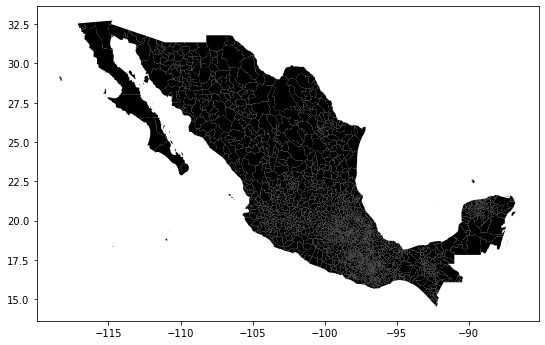

In [8]:
ax = im.plot(color='k', figsize=(9, 9))
#im.loc[w.islands, :].plot(color='red', ax=ax);

<p>En este caso, eliminamos las islas</p>

In [9]:
# Estandariza los renglones de la matriz de pesos
w.transform = 'R'

In [10]:
w['1']

{'14': 0.5, '17': 0.5}

<h2>Retardo espacial</h2>
<p>Una vez que tenemos los datos y la matriz de pesos espaciales, calculamos la variable de retardo espacial del porecntaje de votos a favor de dejar la Unión Europea. El retardo espacial es el producto de la matriz de pesos y la variable, si la matriz de pesos está estandarizada por renglones, el resultado da el porcentaje promedio de votos en la vecindad de una observación</p>

In [11]:
import libpysal.weights as pyw

im['w_im'] = pyw.lag_spatial(w, im['IM'])

In [12]:
im[[ 'IM', 'w_im']].head()

,IM,w_im
CVE_MUN,,
1,48.64,49.235
2,46.38,54.755
3,69.64,69.960
4,51.12,47.385
5,59.54,51.720


In [13]:
w.neighbors['1']

['14', '17']

In [14]:
neis = im.loc[w.neighbors['1'], 'IM']
neis

CVE_MUN
14    54.66
17    43.81
Name: IM, dtype: float64

In [15]:
neis.mean()

49.235

<p>Para algunas aplicaciones hace más sentido el trabajar con una versión estandarizada de la variable, en lugar de la variable original</p>
<p>Esto es, extraer a los valores la media y dividir por la desviación estandar cada observación. Ejemplo:</p>

In [16]:
im['im_std'] = (im['IM'] - im['IM'].mean()) / im['IM'].std()

<p>Finalmente, para poder explorar los patrones espaciales de los valores estandarizads, llamados valores z, necesitamos crear su retardo espacial:</p>

In [17]:
im['w_im_std'] = pyw.lag_spatial(w, im['im_std'])

<h2>Autocorrelación espacial global</h2>
<p> Con la variable estandarizada podemos crear el diagrama de dispersión de Moran</p>

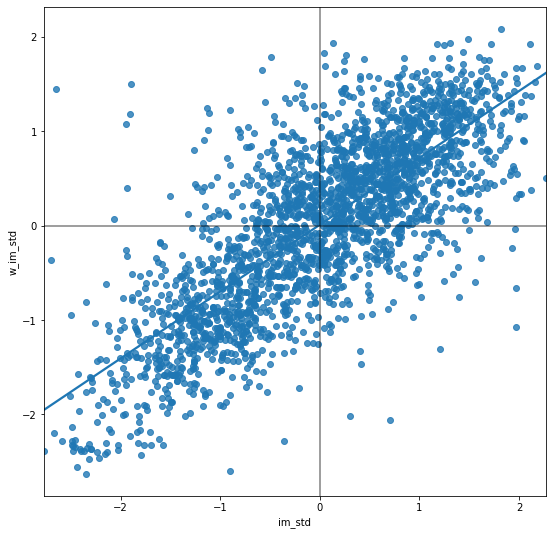

In [18]:
# Ajustamos la figura y los ejes
f, ax = plt.subplots(1, figsize=(9, 9))
# Graficamos 
sns.regplot(x='im_std', y='w_im_std', data=im, ci=None)
# Agergamos líneas horizontal y vertical
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Despliegue
plt.show()

<h3>I de Moran</h3>
<p>A continuación calculamos la I de Moran</p>

In [19]:
import esda
mi = esda.Moran(im['IM'], w)

In [20]:
#Desplegamos el valor de la I de Moran
mi.I

0.7081115681921633

In [21]:
# Obtenemos la pseudo significancia del patrón observado
mi.p_sim

0.001

¿Cómo se interpreta el valor obtenido?

<p> Que no se puede rechazar la hipotesis nula de que el fenomeno es aleatorio, por lo que se deduce que existe autocorrelación espacial a más del 1% de significancia. Tambien es relativamente alta<\p>

<h3> Autocorrelación espacial local </h3>
<p> Recordemos las relaciones en el diagrama de dispersión de moran </p>

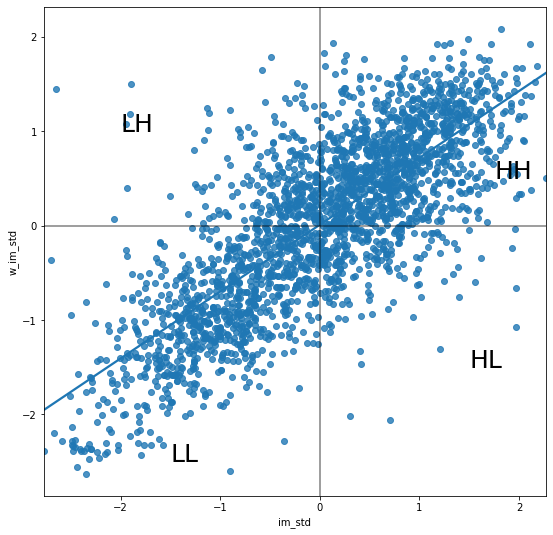

In [22]:
# Ajustamos la figura y los ejes
f, ax = plt.subplots(1, figsize=(9, 9))
# Graficamos los valores
sns.regplot(x='im_std', y='w_im_std', data=im, ci=None)
# Agregamos líneas verticales, horizontales y etiquetas
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.5, "HH", fontsize=25)
plt.text(1.5, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1.5, -2.5, "LL", fontsize=25)
# Desplegamos la gráfica
plt.show()

<p>Calculamos los indicadores locales de asociación espacial. Solo requerimos la variable de interés y la matriz de pesos espaciales</p>

In [23]:
lisa = esda.Moran_Local(im['IM'], w)

In [24]:
# Separa a las observaciones en significativas o no
im['significant'] = lisa.p_sim < 0.05
# Almacenamos el cuadrante al que pertenecen las observaciones
im['quadrant'] = lisa.q

In [25]:
im['significant'].head()

CVE_MUN
1    False
2    False
3    False
4    False
5    False
Name: significant, dtype: bool

<p>Revisamos la pesudo-significancia de las primeras cinco observaciones</p>

In [26]:
lisa.p_sim[:5]

array([0.318, 0.443, 0.118, 0.267, 0.363])

<p>También podemos observar a qué cuadrante pertenecen las observaciones</p>

In [27]:
im['quadrant'].head()

CVE_MUN
1    3
2    3
3    1
4    3
5    4
Name: quadrant, dtype: int64

<p>¿Qué tipo de autocorrelación local corresponde a cada cuadrante?</p>

<p> HH: un municipio con niveles altos del índice de marginación (IM) y vecinos con altos valores del mismo índice.<\p>
<p>HL: un municipio con niveles altos del índice de marginación (IM) y vecinos con bajos valores del mismo índice.<\p>
<p>LH: un municipio con niveles bajos del índice de marginación (IM) y vecinos con altos valores del mismo índice.<\p>
<p>LL: un municipio con niveles bajos del índice de marginación (IM) y vecinos con bajos valores del mismo índice. <\p>

<h3>Mapa de clusters</h3>

In [28]:
x=im[['significant','quadrant']].values
y=[]
for i in range(0,x.shape[0]):
    if x[i,0] ==False:
        y.append('NS')
    elif x[i,0] ==True and x[i,1]==1:
        y.append('HH')
    elif x[i,0] ==True and x[i,1]==3:
        y.append('LL')
    elif x[i,0] ==True and x[i,1]==2:
        y.append('LH')
    elif x[i,0] ==True and x[i,1]==4:
        y.append('HL')

In [29]:
im.insert(im.shape[1], 'LISA',y, True)

Text(0.5, 1.0, 'LISA para el índice de marginación en México')

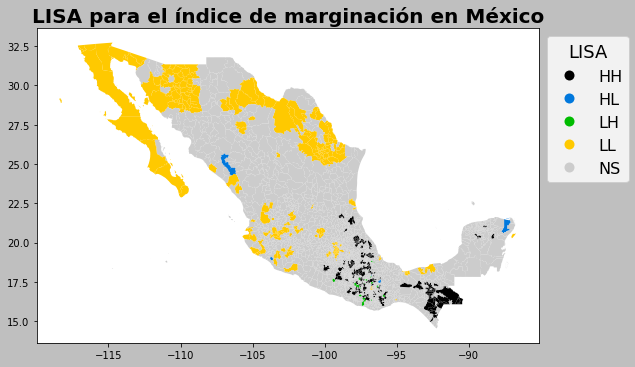

In [50]:
leg_kwds={'title':'LISA','frameon':True,'fontsize': 16,
          'title_fontsize':18 , 'bbox_to_anchor':(1,1),'loc':'upper left'}

# Se ajusta la figura y los ejes
f, ax = plt.subplots(1, figsize=(9, 9))
# Grafica % en favor 
im.plot(column='LISA', cmap='nipy_spectral', categorical=True, 
        legend=True,  legend_kwds=leg_kwds, ax=ax)
# Remueve el marco de los ejes
#ax.set_axis_off()
# Cambia el color de fondo
f.set_facecolor('0.75')
# Titulo
plt.title("LISA para el índice de marginación en México", fontsize=20, fontweight='bold',zorder=2)
